## This code tests how BDT detects anomalies in simulated timeseries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)  

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

from sklearn import tree

from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

from pandas.tseries.offsets import *

import simulated_data
# from graphviz import Source

#### parameters to set

In [2]:
# tuning parameters
cut = 0.55
window = 24

#### generate data

In [3]:
#df =  simulated_data.get_simulated_data()
df =  simulated_data.get_simulated_fixed_data()
df.head()

affected: [1] 2017-08-02 01:00:00 2017-08-02 02:00:00
affected: [1] 2017-08-03 01:00:00 2017-08-03 04:00:00
affected: [1, 3, 4] 2017-08-04 01:00:00 2017-08-04 02:00:00
affected: [1] 2017-08-05 01:00:00 2017-08-05 02:00:00
affected: [1] 2017-08-06 01:00:00 2017-08-06 04:00:00
affected: [1, 3, 4] 2017-08-07 01:00:00 2017-08-07 02:00:00


,link 0,link 1,link 2,link 3,link 4,link 5,flag
2017-08-01 00:00:00,0.234309,0.098391,0.546828,0.290921,0.403015,0.245851,0
2017-08-01 00:00:01,0.230034,0.134577,0.548541,0.288414,0.399936,0.238371,0
2017-08-01 00:00:02,0.225711,0.127967,0.539710,0.287345,0.393710,0.243551,0
2017-08-01 00:00:03,0.231239,0.127110,0.543637,0.283620,0.401527,0.236844,0
2017-08-01 00:00:04,0.231674,0.141980,0.546474,0.290413,0.396456,0.235442,0


#### plot timeseries

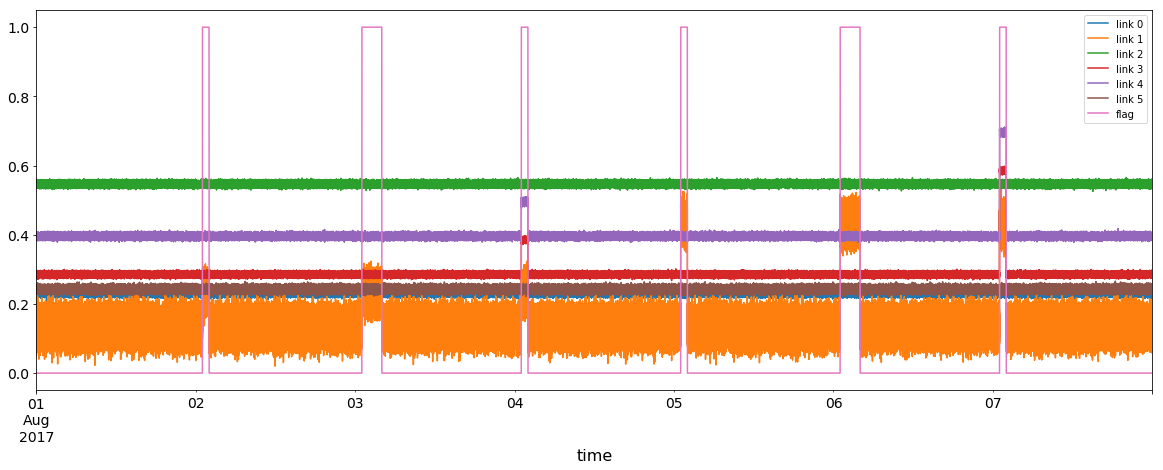

In [4]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("time", fontsize=16)

#### functions

In [5]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.Series([0] * ref.shape[0])
    X_ref = ref
    del X_ref['flag']
    del X_ref['auc_score']
    
    y_sub = pd.Series([1] * sub.shape[0])
    X_sub=sub
    del X_sub['flag']
    del X_sub['auc_score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
#     dtc=DecisionTreeClassifier()
    clf = AdaBoostClassifier() #dtc
#     clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=200)
    
    #train an AdaBoost model to be able to tell the difference between the reference and subject data
    clf.fit(X_train, y_train) 

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    
    # scores = cross_val_score(clf, X, y)
    # print(scores)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    print ("auc_score = ", auc_score, "\tfeature importances:", clf.feature_importances_)
    
#     if auc_score > cut: 
#         plot_roc(fpr, tpr, auc_score)
#         filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
#         tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
#         tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return auc_score

In [6]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

#### Looping over time intervals

In [7]:
df['auc_score']=0.5

#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    auc_score = check_for_anomaly(ref_df, sub_df)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['auc_score']] = auc_score
    print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tauc:', auc_score)
    ti = ti + sub
    count=count+1
    #if count>2: break
    


auc_score =  0.5 	feature importances: [ 0.16  0.08  0.14  0.1   0.26  0.26]
2017-08-02 01:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.958989197531 	feature importances: [ 0.12  0.62  0.08  0.08  0.04  0.06]
2017-08-02 02:00:00 	refes: 86400 	subjects: 3600 	auc: 0.958989197531
auc_score =  0.499980709877 	feature importances: [ 0.04  0.26  0.12  0.1   0.24  0.24]
2017-08-02 03:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.499980709877 	feature importances: [ 0.24  0.2   0.22  0.04  0.2   0.1 ]
2017-08-02 04:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.5 	feature importances: [ 0.08  0.4   0.1   0.18  0.08  0.16]
2017-08-02 05:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.50044367284 	feature importances: [ 0.12  0.32  0.2   0.1   0.18  0.08]
2017-08-02 06:00:00 	refes: 86400 	subjects: 3600 	auc: 0.50044367284
auc_score =  0.5 	feature importances: [ 0.2   0.18  0.26  0.08  0.16  0.12]
2017-08-02 07:0

auc_score =  0.499961419753 	feature importances: [ 0.14  0.22  0.2   0.1   0.12  0.22]
2017-08-04 09:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499961419753
auc_score =  0.499961419753 	feature importances: [ 0.1   0.22  0.08  0.26  0.22  0.12]
2017-08-04 10:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499961419753
auc_score =  0.49994212963 	feature importances: [ 0.08  0.18  0.2   0.18  0.16  0.2 ]
2017-08-04 11:00:00 	refes: 86400 	subjects: 3600 	auc: 0.49994212963
auc_score =  0.5 	feature importances: [ 0.2   0.08  0.2   0.18  0.2   0.14]
2017-08-04 12:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.499980709877 	feature importances: [ 0.3   0.12  0.06  0.18  0.16  0.18]
2017-08-04 13:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.50044367284 	feature importances: [ 0.08  0.28  0.18  0.12  0.26  0.08]
2017-08-04 14:00:00 	refes: 86400 	subjects: 3600 	auc: 0.50044367284
auc_score =  0.5 	feature importances: [ 0.22  0.08  0.26  0.14  0.18  0

auc_score =  0.499980709877 	feature importances: [ 0.14  0.34  0.12  0.1   0.16  0.14]
2017-08-06 17:00:00 	refes: 86400 	subjects: 3600 	auc: 0.499980709877
auc_score =  0.5 	feature importances: [ 0.24  0.24  0.12  0.16  0.08  0.16]
2017-08-06 18:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.500347222222 	feature importances: [ 0.14  0.16  0.14  0.22  0.14  0.2 ]
2017-08-06 19:00:00 	refes: 86400 	subjects: 3600 	auc: 0.500347222222
auc_score =  0.5 	feature importances: [ 0.16  0.32  0.16  0.12  0.1   0.14]
2017-08-06 20:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.1   0.2   0.28  0.1   0.16  0.16]
2017-08-06 21:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.5 	feature importances: [ 0.2   0.2   0.2   0.18  0.1   0.12]
2017-08-06 22:00:00 	refes: 86400 	subjects: 3600 	auc: 0.5
auc_score =  0.499980709877 	feature importances: [ 0.34  0.16  0.08  0.14  0.12  0.16]
2017-08-06 23:00:00 	refes: 86400 	subjects: 3

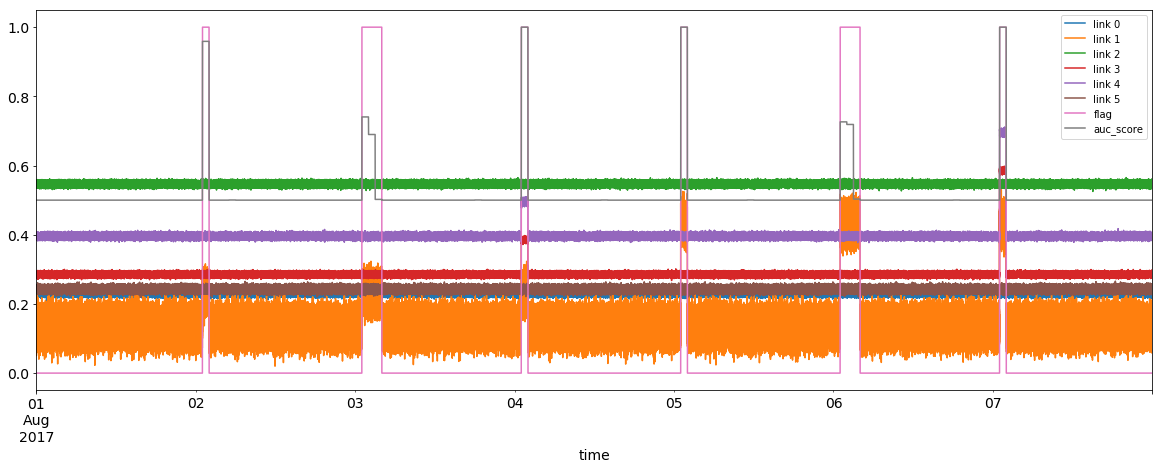

In [8]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)

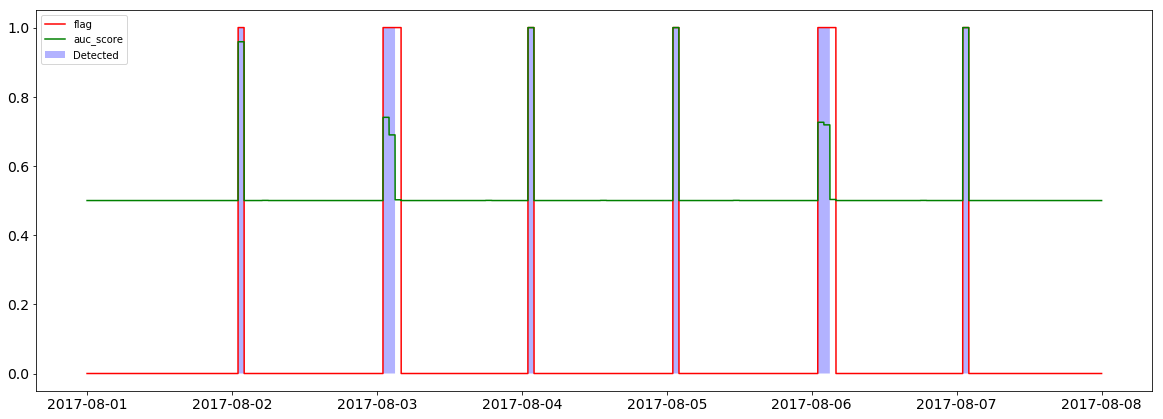

In [9]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.auc_score>0.55,'Detected']=1
df.head()
ax.plot(df.flag, 'r')
ax.plot(df.auc_score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()